# Assignment 3

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [1]:
# Load the libraries as required.
import pandas as pd
from sklearn import linear_model, ensemble
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
import numpy as np

In [2]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [23]:
fires_dt

,coord_x,coord_y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


# Get X and Y

Create the features data frame and target data.

In [3]:
# area is the only column that represents the existance of fire, so its the response variable
# remove the response variable, save the features in X
X = fires_dt.drop(columns=['area'])
X

,coord_x,coord_y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0


In [4]:
# save the response variable 'area' in Y, for sake of practicing renaming, rename it to a better name 
Y = fires_dt["area"].rename('area_caughtby_fire')
Y

0       0.00
1       0.00
2       0.00
3       0.00
4       0.00
       ...  
512     6.44
513    54.29
514    11.16
515     0.00
516     0.00
Name: area_caughtby_fire, Length: 517, dtype: float64

# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [5]:
# droping categorical features (I am not sure if doing this instead of writing them down one-by-one as jesus did would add any problem)
# eventhough X and Y features are numbers, I see them as categorical ? as they are flags for map slicing (something like letters and numbers used for addressing squares in chess)
cat_columns = ['coord_x', 'coord_y', 'month','day']
num_columns = X.drop(columns=cat_columns).columns.astype(str).to_list()
# type(nums_columns.columns.astype(str).to_list())
# print(cat_columns)
# nums_columns


# there is no need to put the transformers inside a pipeline (as there is only one for each), but again for sake of practicing I did that
num_transformer1 = Pipeline([

    ('scaler', StandardScaler())

])

cat_transformer1 = Pipeline([

    ('onehot', OneHotEncoder(handle_unknown='ignore') )
])



preproc1= ColumnTransformer([

    ('numerical_features', num_transformer1, num_columns),
    ('categorical_features', cat_transformer1, cat_columns)
])

preproc1

ColumnTransformer(transformers=[('numerical_features',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh',
                                  'wind', 'rain']),
                                ('categorical_features',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['coord_x', 'coord_y', 'month', 'day'])])

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [6]:
# droping categorical features (I am not sure if doing this instead of writing them down one-by-one as jesus did would add any problem)
cat_columns_name = ['coord_x', 'coord_y', 'month','day']
non_lin_num_columns = ['isi']
lin_num_columns= X.drop(columns=cat_columns_name+ non_lin_num_columns).columns.astype(str).to_list()
# type(num_columns_names.columns.astype(str).to_list())
# print(cat_columns_name)
# num_columns_names


# there is no need to put the transformers inside a pipeline (as there is only one for each), but again for sake of practicing I did that

num_transformer2 = ColumnTransformer([

    ('scaler(linear)', StandardScaler(), lin_num_columns),
    ('log_transformer (non_linear)', FunctionTransformer(np.log1p, validate=True), non_lin_num_columns)

])


""" # if I were to apply scaling to non_lin_nums as well, one way of doing so is to make it a pipeline with a scaler, and then split the non_lin s"""
# num_transformer2 = Pipeline([

#     ('scaler(linear)', StandardScaler()),

#     ('split_non_linears', ColumnTransformer ([
        
#         ('log_transformer (non_linear)', FunctionTransformer(np.log1p, validate=True), non_lin_nums)

#     ], remainder='passthrough')
#     )

# ])


cat_transformer2 = Pipeline([

    ('onehot', OneHotEncoder(handle_unknown='ignore') )
])


preproc2= ColumnTransformer([

    ('numerical_features', num_transformer2, num_columns),
    ('categorical_features', cat_transformer2, cat_columns_name)
])

preproc2

ColumnTransformer(transformers=[('numerical_features',
                                 ColumnTransformer(transformers=[('scaler(linear)',
                                                                  StandardScaler(),
                                                                  ['ffmc',
                                                                   'dmc', 'dc',
                                                                   'temp', 'rh',
                                                                   'wind',
                                                                   'rain']),
                                                                 ('log_transformer '
                                                                  '(non_linear)',
                                                                  FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                      validate=True),
                                                                  ['isi'])]),
                                 ['ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh',
                                  'wind', 'rain']),
                                ('categorical_features',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['coord_x', 'coord_y', 'month', 'day'])])

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [7]:
baseline_model = linear_model.Ridge()
advanced_model = ensemble.RandomForestRegressor(random_state=42)

In [8]:
# Pipeline A = preproc1 + baseline

pipeline_a = Pipeline([
    ("preprocessing", preproc1),
    ("model", baseline_model)
])


In [9]:
# Pipeline B = preproc2 + baseline

pipeline_b = Pipeline([
    ("preprocessing", preproc2),
    ("model", baseline_model)
])

In [10]:
# Pipeline C = preproc1 + advanced model

pipeline_c = Pipeline([
    ("preprocessing", preproc1),
    ("model", advanced_model)
])

In [11]:
# Pipeline D = preproc2 + advanced model

pipeline_d = Pipeline([
    ("preprocessing", preproc2),
    ("model", advanced_model)
])

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [12]:
baseline_model_params = {'model__alpha': [0.1, 0.13, 1.0, 5]}  # Ridge regularization strength
advanced_model_params = {
    'model__n_estimators': [50, 100, 150, 200],  # Number of trees
    'model__max_depth': [5, 10, 15, None]  # Tree depth
}
selected_scoring='neg_root_mean_squared_error'
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# print(X_train.isna().sum())
# print(Y_train.isna().sum())
# print((X_train == np.inf).sum())
# print((Y_train == np.inf).sum())


In [13]:
grid_a = GridSearchCV(
    pipeline_a, 
    param_grid=baseline_model_params, 
    cv=5, 
    scoring= selected_scoring, 
    # won't use refit=  as Jesus's Instruction, beacuse we have only one scoring method
)
grid_a.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('numerical_features',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('categorical_features',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'month',
                                                                          'day'])])),
                                       ('model', Ridge())]),
             param_grid={'model__alpha': [0.1, 0.13, 1.0, 5]},
             scoring='neg_root_mean_squared_error')

In [14]:
grid_b = GridSearchCV(
    pipeline_b, 
    param_grid=baseline_model_params, 
    cv=5,  
    scoring= selected_scoring
)
grid_b.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('numerical_features',
                                                                         ColumnTransformer(transformers=[('scaler(linear)',
                                                                                                          StandardScaler(),
                                                                                                          ['ffmc',
                                                                                                           'dmc',
                                                                                                           'dc',
                                                                                                           'temp',
                                                                                                           'rh',
                                                                                                           'wind',
                                                                                                           'rain']),
                                                                                                         ('log_transformer '
                                                                                                          '(non_linear)',
                                                                                                          FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                                                              validate=True),
                                                                                                          ['isi'])]),
                                                                         ['ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('categorical_features',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'month',
                                                                          'day'])])),
                                       ('model', Ridge())]),
             param_grid={'model__alpha': [0.1, 0.13, 1.0, 5]},
             scoring='neg_root_mean_squared_error')

In [15]:
grid_c = GridSearchCV(
    pipeline_c, 
    param_grid=advanced_model_params, 
    cv=5,  
    scoring= selected_scoring
)
grid_c.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('numerical_features',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('categorical_features',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'month',
                                                                          'day'])])),
                                       ('model',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'model__max_depth': [5, 10, 15, None],
                         'model__n_estimators': [50, 100, 150, 200]},
             scoring='neg_root_mean_squared_error')

In [16]:
grid_d = GridSearchCV(
    pipeline_d, 
    param_grid=advanced_model_params, 
    cv=5,  
    scoring= selected_scoring
)
grid_d.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('numerical_features',
                                                                         ColumnTransformer(transformers=[('scaler(linear)',
                                                                                                          StandardScaler(),
                                                                                                          ['ffmc',
                                                                                                           'dmc',
                                                                                                           'dc',
                                                                                                           'temp',
                                                                                                           'rh',
                                                                                                           'wind',
                                                                                                           'rain']),
                                                                                                         ('log_transformer '
                                                                                                          '(non_linear)',
                                                                                                          FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                                                              validate=True),
                                                                                                          ['isi'])]),
                                                                         ['ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('categorical_features',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'month',
                                                                          'day'])])),
                                       ('model',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'model__max_depth': [5, 10, 15, None],
                         'model__n_estimators': [50, 100, 150, 200]},
             scoring='neg_root_mean_squared_error')

# Evaluate

+ Which model has the best performance?

In [39]:
res = grid_a.cv_results_
res = pd.DataFrame(res)
res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.009208,1.167308e-03,0.003403,0.000490,0.10,{'model__alpha': 0.1},-42.090464,-18.976241,-37.842449,-85.624698,-26.716417,-42.250054,23.167980,3
1,0.008007,2.611745e-07,0.002803,0.000400,0.13,{'model__alpha': 0.13},-42.079041,-18.972112,-37.880666,-85.612291,-26.714680,-42.251758,23.162965,4
2,0.007207,4.005435e-04,0.003203,0.000400,1.00,{'model__alpha': 1.0},-41.878071,-18.918556,-38.336492,-85.436157,-26.645759,-42.243007,23.101283,2
3,0.008007,8.949490e-04,0.003803,0.000749,5.00,{'model__alpha': 5},-41.590492,-18.591518,-37.751099,-85.251628,-26.160604,-41.869068,23.184831,1


In [44]:
results = {
    'Pipeline A': max(grid_a.cv_results_['mean_test_score']),
    'Pipeline B': max(grid_b.cv_results_['mean_test_score']),
    'Pipeline C': max(grid_c.cv_results_['mean_test_score']),
    'Pipeline D': max(grid_d.cv_results_['mean_test_score'])
}
print(results)

# Find the best-performing pipeline
best_pipeline_name = max(results, key=results.get)
best_pipeline_score = results[best_pipeline_name]

print(f"Best pipeline: {best_pipeline_name} with Negative RMSE: {best_pipeline_score:.2f}")

{'Pipeline A': -41.86906810991722, 'Pipeline B': -41.84380549931152, 'Pipeline C': -47.761186939628246, 'Pipeline D': -48.14033695299661}
Best pipeline: Pipeline B with Negative RMSE: -41.84


# Export

+ Save the best performing model to a pickle file.

In [45]:
import pickle

# Save the best model
best_pipeline = {'Pipeline A': grid_a, 'Pipeline B': grid_b, 'Pipeline C': grid_c, 'Pipeline D': grid_d}[best_pipeline_name].best_estimator_
best_pipeline


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numerical_features',
                                                  ColumnTransformer(transformers=[('scaler(linear)',
                                                                                   StandardScaler(),
                                                                                   ['ffmc',
                                                                                    'dmc',
                                                                                    'dc',
                                                                                    'temp',
                                                                                    'rh',
                                                                                    'wind',
                                                                                    'rain']),
                                                                                  ('log_transformer '
                                                                                   '(non_linear)',
                                                                                   FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                                       validate=True),
                                                                                   ['isi'])]),
                                                  ['ffmc', 'dmc', 'dc', 'isi',
                                                   'temp', 'rh', 'wind',
                                                   'rain']),
                                                 ('categorical_features',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['coord_x', 'coord_y',
                                                   'month', 'day'])])),
                ('model', Ridge(alpha=5))])

In [46]:
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_pipeline, f)

# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

In [50]:
import shap
data_transform = best_pipeline.named_steps["preprocessing"].transform(X_test).toarray()


""" this code below is not working as I have used log transformer in the preproc, this transformer deosn't work
with the get_feature_names_out, so have to manually add them"""
# explainer = shap.explainers.Linear(

#     best_pipeline.named_steps['model'],
#     data_transform,
#     # consult the pipeline to get the features names, as transformation process changes the order of the columns 
#     feature_names = best_pipeline.named_steps["preprocessing"].get_feature_names_out() 

# )
# shap_values = explainer(data_transform)



# try: 
#     feature_names = best_pipeline.named_steps["preprocessing"].get_feature_names_out()


# except AttributeError:
#     feature_names = [f"feature_{i}" for i in range(data_transform.shape[1])]


# feature_names


""" first attempt to manually add the features names for transformers not supporting get_feature_names_out """
# feature_names = []
# i=0
# for thing in preprocessing:
#     print(thing[1])
    
#     if isinstance(thing[1], ColumnTransformer):
#         # print('in ColumnTransformer')
#         # print(thing[1].transformers_)
#         i=0
#         for transformer in thing[1].transformers_:
#             try:
#                 feature_name = transformer.get_feature_names_out()
#             except AttributeError:
#                 feature_name = f"feature_{i}_from_{thing[0]}"
#             feature_names.append(feature_name)
#             i += 1

#     if thing[1] == "Pipeline":
#         print('pipe')
    

# feature_names
# best_pipeline.named_steps['model']
# X_test
# type(data_transform)


""" add feature names manually for transformers not supporting get_feature_names_out"""
preprocessing = best_pipeline.named_steps["preprocessing"].transformers_
print(preprocessing)

feature_names = []

# given the fact that I know the construction of these preprocessing pipes to an extent, catch the transformers
for name, transformer, columns in preprocessing:
        if hasattr(transformer, 'transformers'):    # catch the possible columntransformer 
            print("found columntransformer")
            # print(transformer)

    
            for sub_name, sub_transformer, sub_columns in transformer.transformers_:
                # print("made it here1")
                if hasattr(sub_transformer, "get_feature_names_out"):
                    # Get transformed feature names
                    
                    # print(sub_transformer)
                    transformed_feature_names = sub_transformer.get_feature_names_out()
                    feature_names.extend(transformed_feature_names)
                    # print("made it here2")
                else:
                    # Use original column names if transformer doesn't support get_feature_names_out
                    print("using original name for", sub_name)
                    feature_names.extend(sub_columns) 
                    

        else: 


                # Check if the transformer supports get_feature_names_out
                if hasattr(transformer, "get_feature_names_out"):
                    # Get transformed feature names
                    transformed_feature_names = transformer.get_feature_names_out()
                    feature_names.extend(transformed_feature_names)
                else:
                    # Use original column names if transformer doesn't support get_feature_names_out
                    feature_names.extend(columns)



print("feuater names are:")
for feature_name in feature_names:
    print(feature_name)
# len(feature_names)
                    

# given the fact that our best pipeline is the one using Ridge, a Linear model
explainer = shap.explainers.Linear(

    best_pipeline.named_steps['model'],
    data_transform,
    feature_names = feature_names

)
shap_values = explainer(data_transform)




[('numerical_features', ColumnTransformer(transformers=[('scaler(linear)', StandardScaler(),
                                 ['ffmc', 'dmc', 'dc', 'temp', 'rh', 'wind',
                                  'rain']),
                                ('log_transformer (non_linear)',
                                 FunctionTransformer(func=<ufunc 'log1p'>,
                                                     validate=True),
                                 ['isi'])]), ['ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']), ('categorical_features', Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]), ['coord_x', 'coord_y', 'month', 'day'])]
found columntransformer
using original name for log_transformer (non_linear)
feuater names are:
ffmc
dmc
dc
temp
rh
wind
rain
isi
coord_x_1
coord_x_2
coord_x_3
coord_x_4
coord_x_5
coord_x_6
coord_x_7
coord_x_8
coord_x_9
coord_y_2
coord_y_3
coord_y_4
coord_y_5
coord_y_6
coord_y_8
coord_y_9
month_apr
month_aug
month_dec
month_feb
month

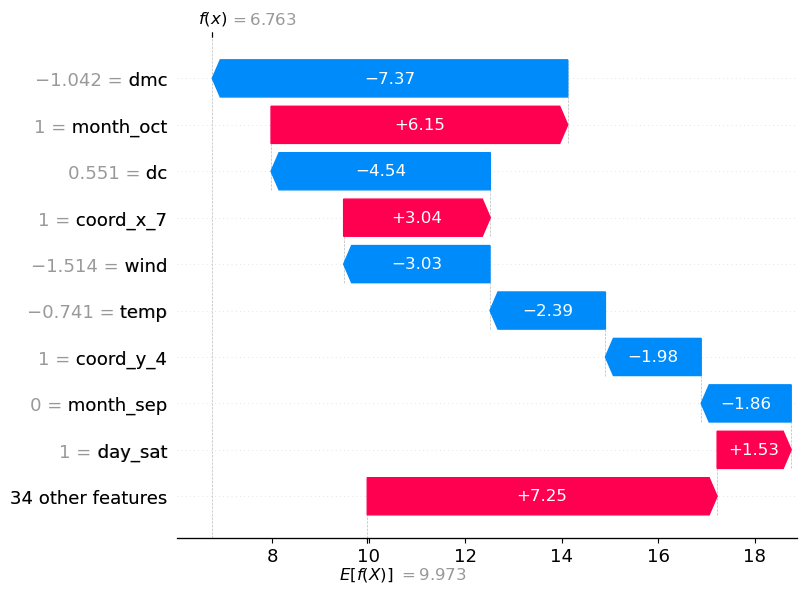

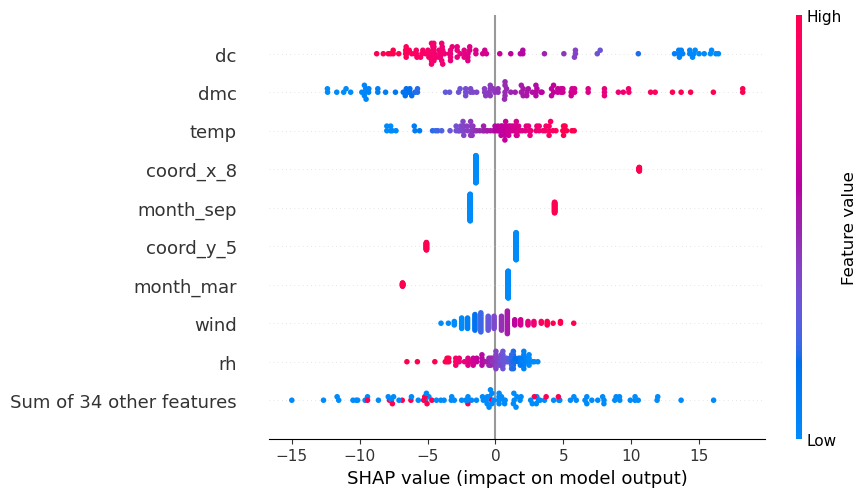

In [35]:
shap.plots.waterfall(shap_values[56])
shap.plots.beeswarm(shap_values)


Generally any feature that appears on top of either beeswarm or waterfall diagrams is the most important feature, importance decreases as you go down.

for the 57th observation (row), the dmc is the most important feature contributing the most to the prediction whereas generally on the beeswarm diagram, dc holds the first place.

for instance in the beeswarm diagram, higher values of dc, being in negative shap values (left), lower the value of the prediction and vice versa. 

Finally for removing features, we have to go with ones appearing at the bottom, as they have less pull over the response variable. This has to be tested by retrianing the model without the removed feature and comparing the performance of the new model. if there is no significant change, that feature can probably be removed.

## Criteria

The [rubric](./assignment_3_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.